# Alexa Sentiment Analysis

In [1]:
pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 13.4 MB/s eta 0:00:00


## Import Library

In [2]:
# ini adalah untuk import library
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import emoji
import warnings
warnings.filterwarnings("ignore")

nltk.download("stopwords")
nltk.download("wordnet")
plt.style.use("seaborn-v0_8")
sns.set_palette("Set2")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## Load Dataset

In [3]:
df = pd.read_csv("amazon_alexa.tsv", sep="\t")

In [4]:
df

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1
...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"Perfect for kids, adults and everyone in betwe...",1
3146,5,30-Jul-18,Black Dot,"Listening to music, searching locations, check...",1
3147,5,30-Jul-18,Black Dot,"I do love these things, i have them running my...",1
3148,5,30-Jul-18,White Dot,Only complaint I have is that the sound qualit...,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3149 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [6]:
df.describe()

,rating,feedback
count,3150.000000,3150.000000
mean,4.463175,0.918413
std,1.068506,0.273778
min,1.000000,0.000000
25%,4.000000,1.000000
50%,5.000000,1.000000
75%,5.000000,1.000000
max,5.000000,1.000000


## EDA

### Distribusi Rating

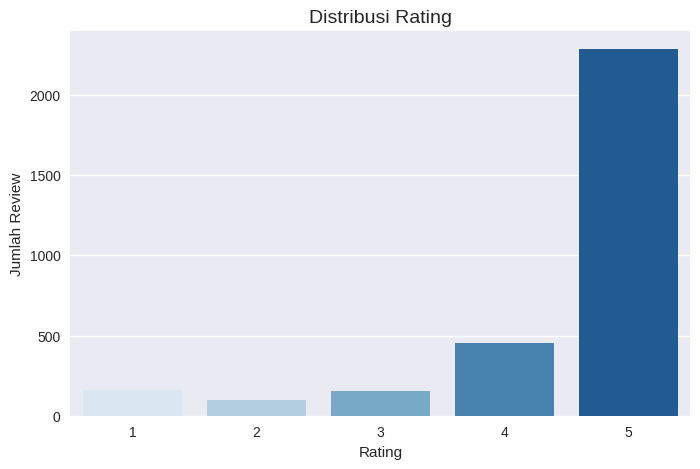

In [7]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="rating", palette="Blues")
plt.title("Distribusi Rating", fontsize=14)
plt.xlabel("Rating")
plt.ylabel("Jumlah Review")
plt.show()

Dari plot distribusi rating, terlihat bahwa mayoritas ulasan memiliki rating tinggi, yaitu rating 5 mendominasi dengan jumlah review terbanyak, diikuti oleh rating 4. Ini menunjukkan bahwa sebagian besar pengguna memberikan feedback positif atau sangat puas dengan produk. Rating 1, 2, dan 3 memiliki jumlah ulasan yang jauh lebih sedikit, mengindikasikan bahwa ulasan negatif atau netral relatif jarang.

### Distribusi Feedback (0=Negatif, 1=Positif)

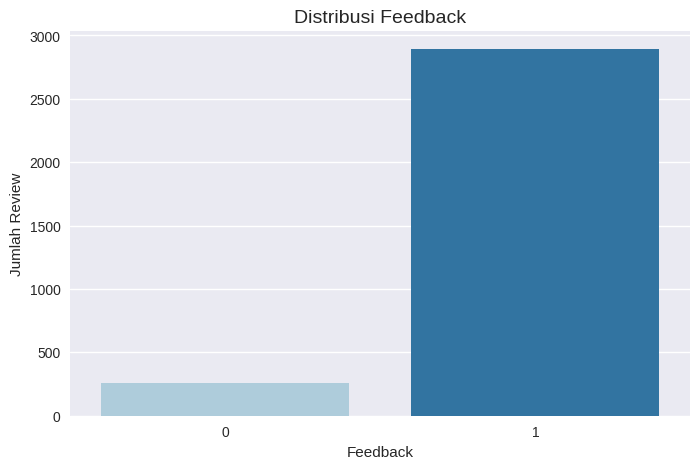

In [8]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="feedback", palette='Paired')
plt.title("Distribusi Feedback", fontsize=14)
plt.xlabel("Feedback")
plt.ylabel("Jumlah Review")
plt.show()

dapat dilihat bahwa ada perbedaan yang cukup jauh antara review positif dan review negatif sehingga kita akan melakukan handling imbalance data dengan SMOTE

### Top 15 Variation

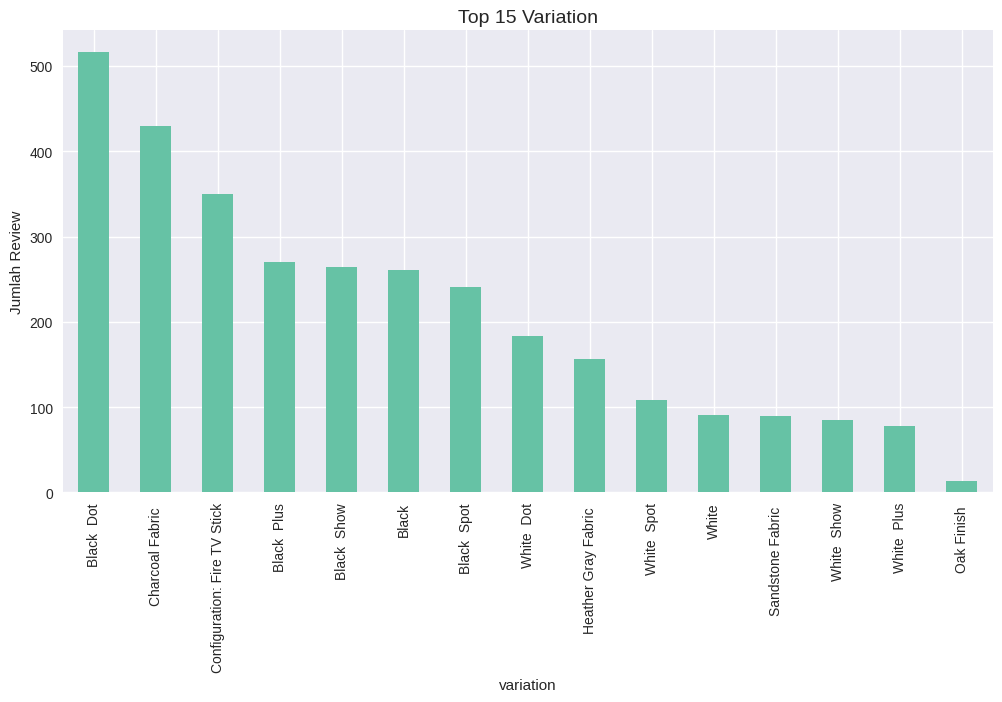

In [9]:
plt.figure(figsize=(12,6))
df["variation"].value_counts().head(15).plot(kind="bar")
plt.title("Top 15 Variation", fontsize=14)
plt.ylabel("Jumlah Review")
plt.show()

Top 15 variation didominasi oleh variasi "Black Dot" dan "Charcoal Fabric" dengan jumlah review terbanyak, diikuti oleh beberapa variasi lain seperti "Configuration: Fire TV Stick", "Black Show", dan "Black Plus".

### Feedback vs Variation (Top 10)

<Figure size 1400x600 with 0 Axes>

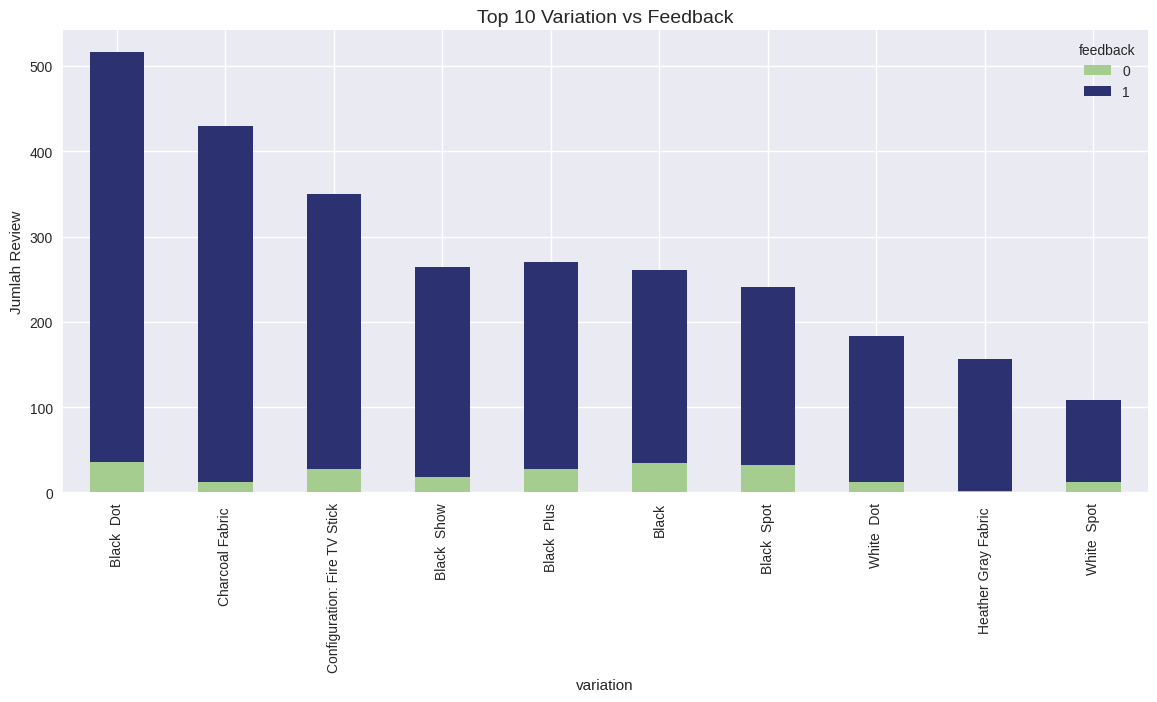

In [10]:
plt.figure(figsize=(14,6))
variation_feedback = pd.crosstab(df["variation"], df["feedback"])
variation_feedback = variation_feedback.sort_values(by=1, ascending=False).head(10)
variation_feedback.plot(kind="bar", stacked=True, figsize=(14,6), colormap="crest")
plt.title("Top 10 Variation vs Feedback", fontsize=14)
plt.ylabel("Jumlah Review")
plt.show()

terlihat bahwa pada sebagian besar variasi teratas , jumlah review positif jauh lebih banyak dibandingkan review negatif

### Analisis Panjang Review

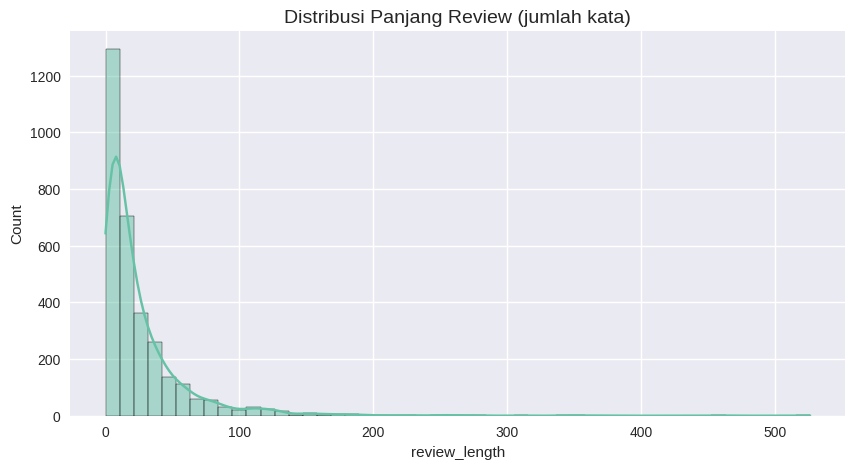

In [11]:
df["review_length"] = df["verified_reviews"].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10,5))
sns.histplot(df["review_length"], bins=50, kde=True)
plt.title("Distribusi Panjang Review (jumlah kata)", fontsize=14)
plt.show()

Berdasarkan plot distribusi panjang review, terlihat bahwa mayoritas review memiliki panjang yang relatif pendek, dengan puncak distribusi berada pada jumlah kata yang sedikit. Distribusi ini menunjukkan ekor panjang ke kanan, menandakan ada beberapa review yang sangat panjang, namun jumlahnya jauh lebih sedikit dibandingkan review pendek.

**hmmm , saya penasaran nih kalo reviewnya panjang itu biasanya positif apa negatif yahh . lets figure out**

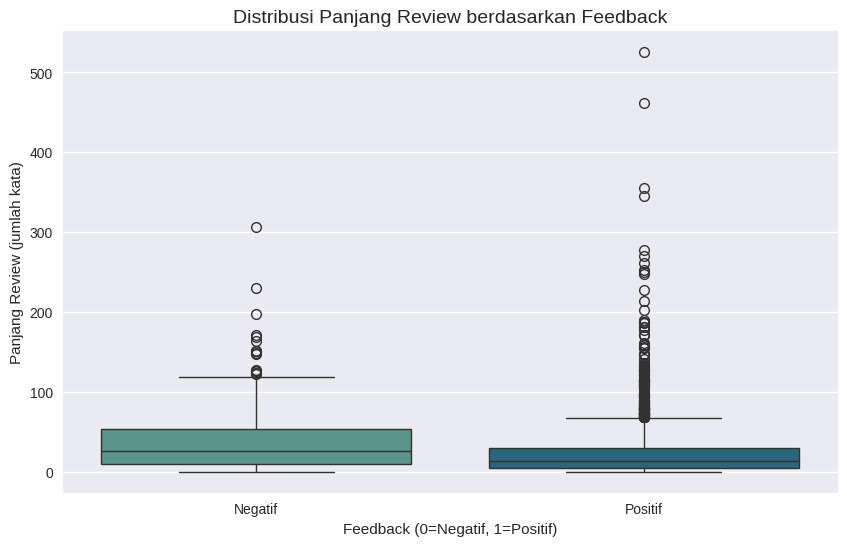

In [12]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="feedback", y="review_length", palette="crest")
plt.title("Distribusi Panjang Review berdasarkan Feedback", fontsize=14)
plt.xlabel("Feedback (0=Negatif, 1=Positif)")
plt.ylabel("Panjang Review (jumlah kata)")
plt.xticks([0, 1], ["Negatif", "Positif"])
plt.show()

kita lihat 100 review terpanjang

Jumlah feedback positif dan negatif dalam 100 review terpanjang:
feedback
1    79
0    21
Name: count, dtype: int64


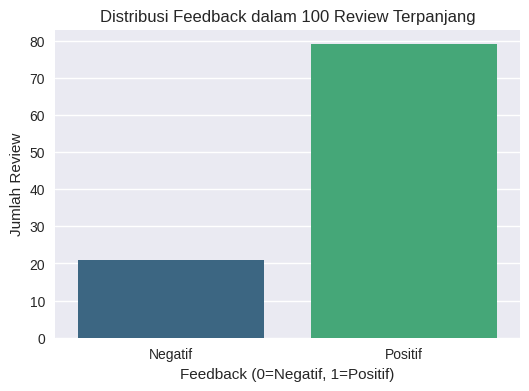

In [13]:
# Select the top 100 longest reviews (assuming 'longest_reviews' DataFrame already exists from previous steps)
top_100_longest_reviews = df.sort_values(by="review_length", ascending=False).head(100)

# Counting
feedback_counts_top_100 = top_100_longest_reviews["feedback"].value_counts()

# Display the counts
print("Jumlah feedback positif dan negatif dalam 100 review terpanjang:")
print(feedback_counts_top_100)

# Optional: Plot the counts
plt.figure(figsize=(6,4))
sns.barplot(x=feedback_counts_top_100.index, y=feedback_counts_top_100.values, palette="viridis")
plt.title("Distribusi Feedback dalam 100 Review Terpanjang")
plt.xlabel("Feedback (0=Negatif, 1=Positif)")
plt.ylabel("Jumlah Review")
plt.xticks([0, 1], ["Negatif", "Positif"])
plt.show()

### Analisis Bigram dan Unigram pada sentimen negatif

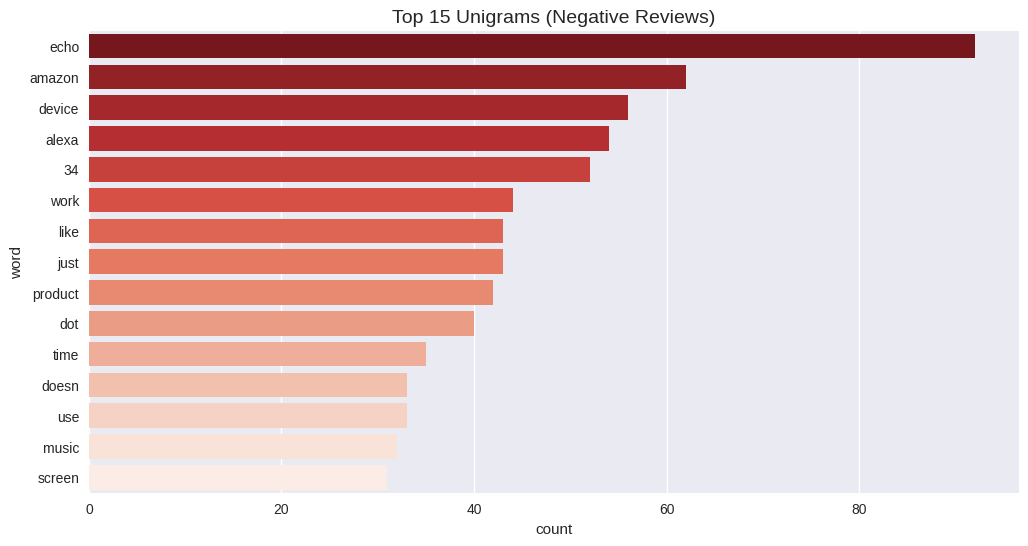

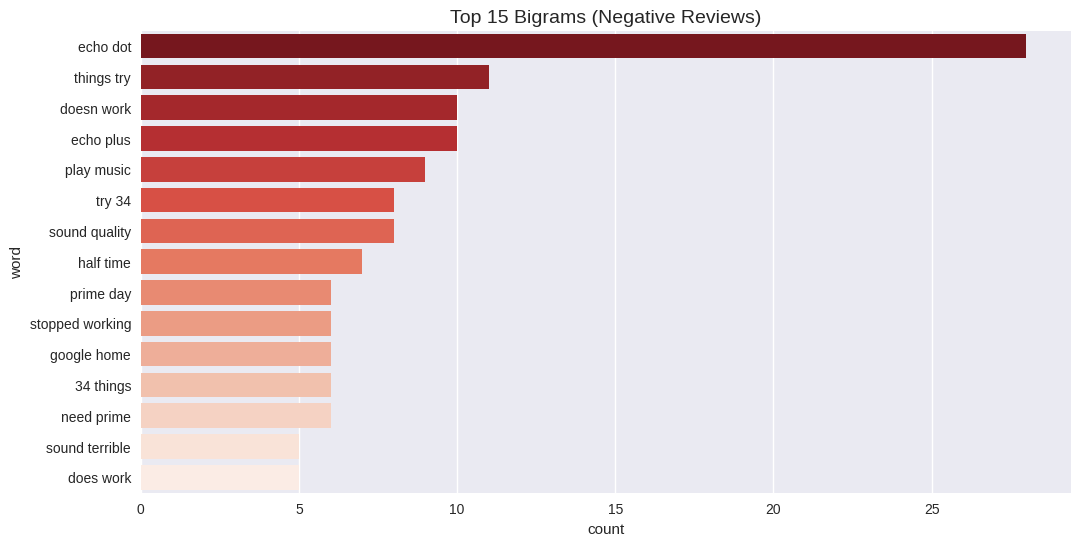

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

def plot_top_ngrams(corpus, ngram_range=(1,1), n=15, title="Top Words"):
    corpus = corpus.fillna('')
    vec = CountVectorizer(stop_words="english", ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]
    words_df = pd.DataFrame(words_freq, columns=["word", "count"])

    plt.figure(figsize=(12,6))
    sns.barplot(x="count", y="word", data=words_df, palette="Reds_r")
    plt.title(title, fontsize=14)
    plt.show()

neg_reviews = df.loc[df["feedback"] == 0, "verified_reviews"]

# Top unigram negatif
plot_top_ngrams(
    neg_reviews,
    ngram_range=(1,1),
    n=15,
    title="Top 15 Unigrams (Negative Reviews)"
)

# Top bigram negatif
plot_top_ngrams(
    neg_reviews,
    ngram_range=(2,2),
    n=15,
    title="Top 15 Bigrams (Negative Reviews)"
)

Dari analisis top 15 unigram pada review negatif, kata-kata seperti "echo", "amazon", "device", dan "alexa" muncul sebagai yang paling sering disebutkan. Hal ini menunjukkan bahwa masalah atau ketidakpuasan pengguna sering kali terkait langsung dengan produk atau merek itu sendiri. Sementara itu, top 15 bigram pada review negatif menyoroti frasa seperti "echo dot", "doesn work", dan "sound quality", yang memberikan wawasan lebih spesifik mengenai isu-isu umum yang dihadapi pengguna dengan perangkat Echo Dot, fungsionalitas produk, dan kualitas audio. Analisis ini membantu mengidentifikasi area-area kunci yang memerlukan perhatian untuk meningkatkan kepuasan pengguna dan mengurangi feedback negatif.

### WordCloud Positif & Negatif

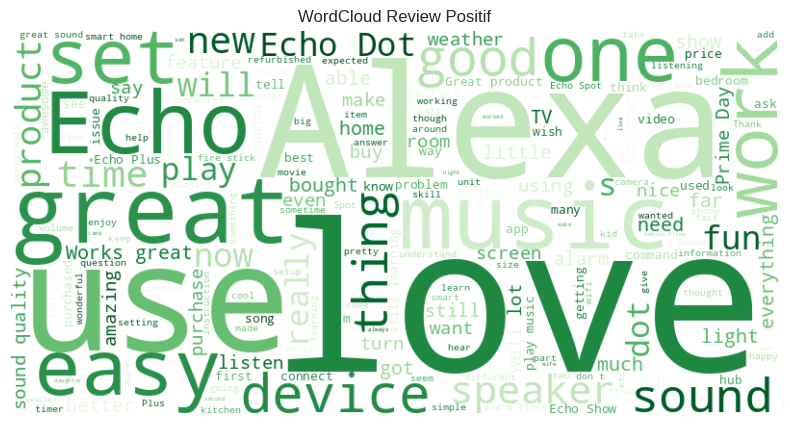

In [15]:
from wordcloud import WordCloud

positive_text = " ".join(df[df["feedback"] == 1]["verified_reviews"].astype(str))
wordcloud_pos = WordCloud(width=800, height=400, background_color="white", colormap="Greens").generate(positive_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud Review Positif")
plt.show()

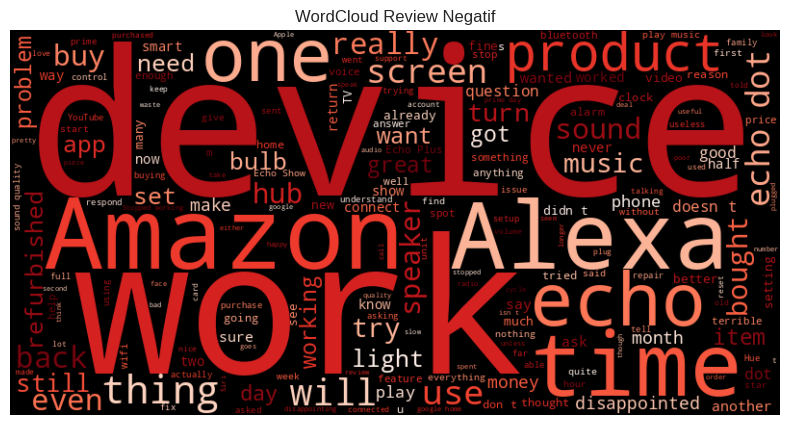

In [16]:
negative_text = " ".join(df[df["feedback"] == 0]["verified_reviews"].astype(str))
wordcloud_neg = WordCloud(width=800, height=400, background_color="black", colormap="Reds").generate(negative_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud Review Negatif")
plt.show()

dari WordCloud Review Positif, kata-kata yang menonjol antara lain "love", "echo", "great", "alexa", "music", "easy", dan "works", menunjukkan aspek-aspek positif yang paling sering disebutkan oleh pengguna. Sementara itu, dari WordCloud Review Negatif, kata-kata yang sering muncul adalah "product", "speaker", "work", "device", "time", "sound", dan "problem", mengindikasikan area masalah atau ketidakpuasan pengguna yang dapat diselidiki lebih lanjut

### Korelasi Numerik

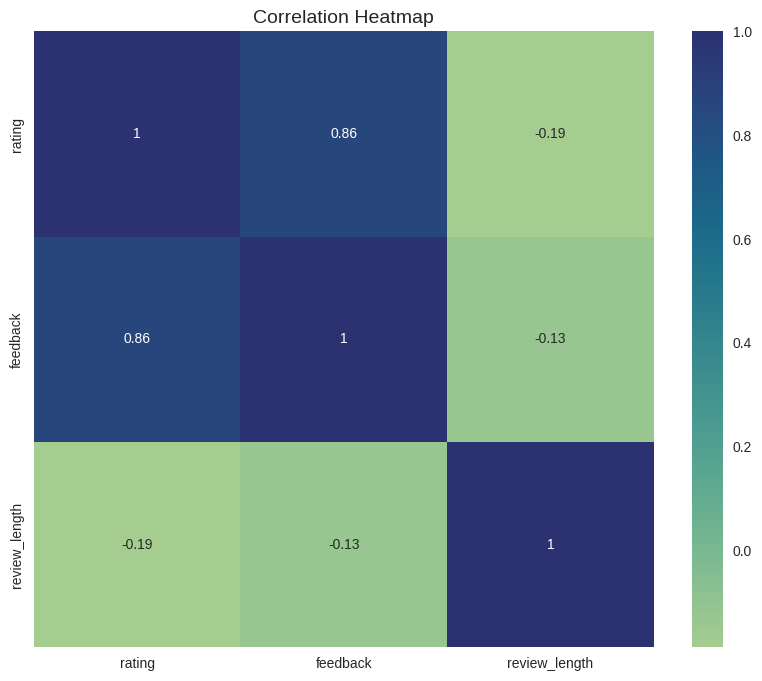

In [17]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="crest")
plt.title("Correlation Heatmap", fontsize=14)
plt.show()

Terdapat korelasi positif yang kuat antara rating dan feedback, yang sudah diperkirakan karena feedback 1 (positif) umumnya terkait dengan rating tinggi. Korelasi dengan panjang review relatif lemah.

## Text Processing

In [18]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # lowercase dan hilangkan non ascii
    text = re.sub(r'[^\x00-\x7F]+', ' ', str(text).lower())
    # 2. menghilangkan punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    # menghilangkan angka
    text = re.sub(r"\d+", " ", text)
    # menghilangkan emoji
    text = emoji.replace_emoji(text, replace=" ")
    # menghilangkan extra whitespace
    text = re.sub(r"\s+", " ", text).strip()
    # tokenisasi
    words = text.split()
    # menghapus stopwords
    words = [w for w in words if w not in stop_words]
    # menghandle negasi (contoh: "not good" → "not_good")
    new_words = []
    skip = False
    for i, word in enumerate(words):
        if word == "not" and i+1 < len(words):
            new_words.append("not_" + words[i+1])
            skip = True
        elif skip:
            skip = False
            continue
        else:
            new_words.append(word)
    words = new_words

    words = [lemmatizer.lemmatize(w) for w in words]
    return " ".join(words)

In [19]:
# Drop NA pada verified_reviews
df = df.dropna(subset=["verified_reviews"]).copy()

In [20]:
# Tambahkan kolom clean_review
df["clean_review"] = df["verified_reviews"].apply(clean_text)

In [21]:
# Cek hasil
df[["verified_reviews", "clean_review"]].head()

,verified_reviews,clean_review
0,Love my Echo!,love echo
1,Loved it!,loved
2,"Sometimes while playing a game, you can answer...",sometimes playing game answer question correct...
3,I have had a lot of fun with this thing. My 4 ...,lot fun thing yr old learns dinosaur control l...
4,Music,music


## Train Test Split + FE

In [22]:
# Fitur & Target
X_text = df["clean_review"]
X_var = df["variation"]
y = df["feedback"]

In [23]:
# Train-Test Split
X_train_text, X_test_text, X_train_var, X_test_var, y_train, y_test = train_test_split(
    X_text, X_var, y, test_size=0.2, random_state=42, stratify=y
)

In [24]:
# TF-IDF untuk teks
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf = vectorizer.transform(X_test_text)

In [25]:
# One-hot encoding untuk variation
ohe = OneHotEncoder(handle_unknown="ignore")
X_train_var_enc = ohe.fit_transform(X_train_var.to_frame())
X_test_var_enc = ohe.transform(X_test_var.to_frame())

In [26]:
# Gabungkan TF-IDF + Variation
X_train_final = hstack([X_train_tfidf, X_train_var_enc])
X_test_final = hstack([X_test_tfidf, X_test_var_enc])

print("bentuk TF-IDF Train:", X_train_tfidf.shape)
print("bentuk Variation Train:", X_train_var_enc.shape)
print("bentuk Final Train:", X_train_final.shape)

bentuk TF-IDF Train: (2519, 5000)
bentuk Variation Train: (2519, 16)
bentuk Final Train: (2519, 5016)


In [27]:
# Handling Imbalanced Data dengan SMOTE
# Terapkan SMOTE hanya pada data train
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_final, y_train)

print("Distribusi kelas sebelum SMOTE:", np.bincount(y_train))
print("Distribusi kelas sesudah SMOTE:", np.bincount(y_train_bal))


Distribusi kelas sebelum SMOTE: [ 205 2314]
Distribusi kelas sesudah SMOTE: [2314 2314]


## Modelling

### Logistic Regression

Accuracy: 0.9

Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.73      0.54        51
           1       0.97      0.92      0.94       579

    accuracy                           0.90       630
   macro avg       0.70      0.82      0.74       630
weighted avg       0.93      0.90      0.91       630



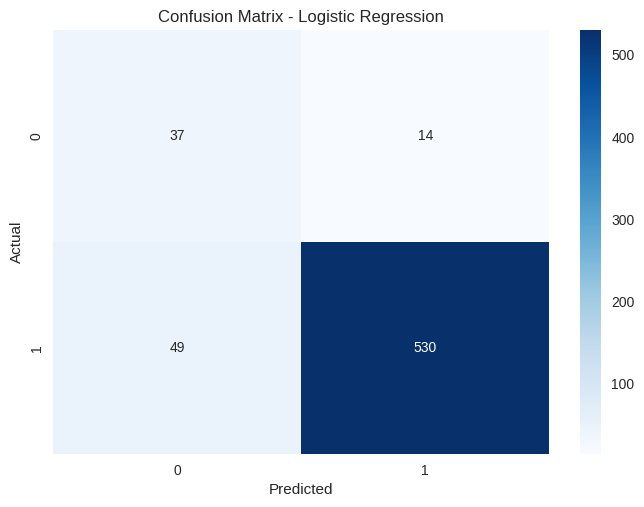

In [28]:
# Train
lr = LogisticRegression(max_iter=500)
lr.fit(X_train_bal, y_train_bal)

# Predict
y_pred_lr = lr.predict(X_test_final)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

### Naive Bayes

Accuracy: 0.8809523809523809

Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.78      0.52        51
           1       0.98      0.89      0.93       579

    accuracy                           0.88       630
   macro avg       0.68      0.84      0.72       630
weighted avg       0.93      0.88      0.90       630



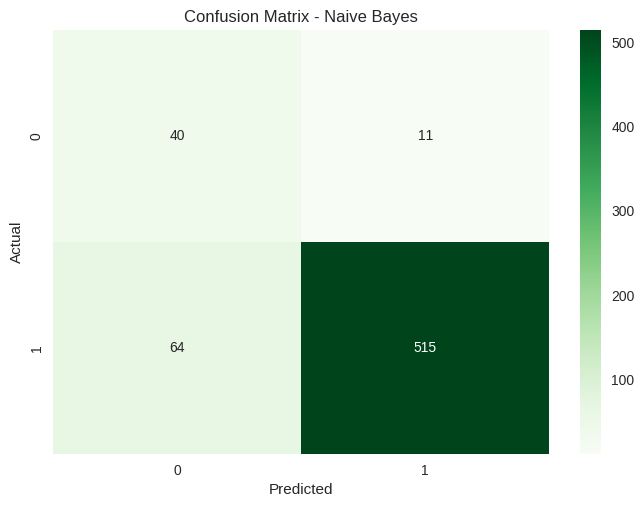

In [29]:

# Train
nb = MultinomialNB()
nb.fit(X_train_bal, y_train_bal)

# Predict
y_pred_nb = nb.predict(X_test_final)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Naive Bayes")
plt.show()

### Random Forest

Accuracy: 0.9238095238095239

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.33      0.41        51
           1       0.94      0.98      0.96       579

    accuracy                           0.92       630
   macro avg       0.75      0.65      0.69       630
weighted avg       0.91      0.92      0.92       630



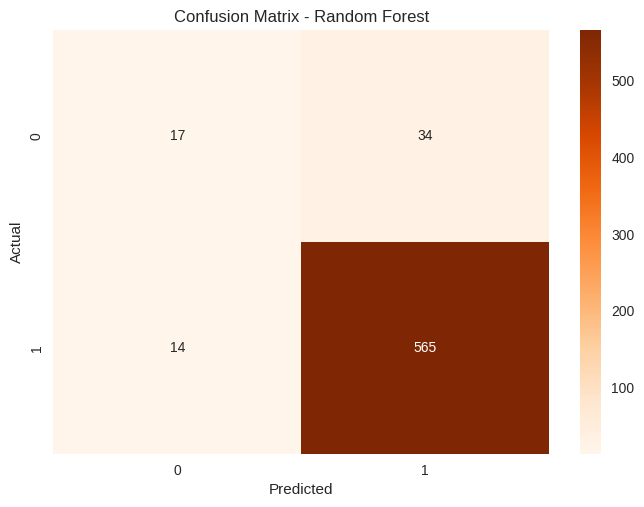

In [30]:
# Train
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_bal, y_train_bal)

# Predict
y_pred_rf = rf.predict(X_test_final)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

### XGBoost

Accuracy: 0.9301587301587302

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.49      0.53        51
           1       0.96      0.97      0.96       579

    accuracy                           0.93       630
   macro avg       0.77      0.73      0.75       630
weighted avg       0.93      0.93      0.93       630



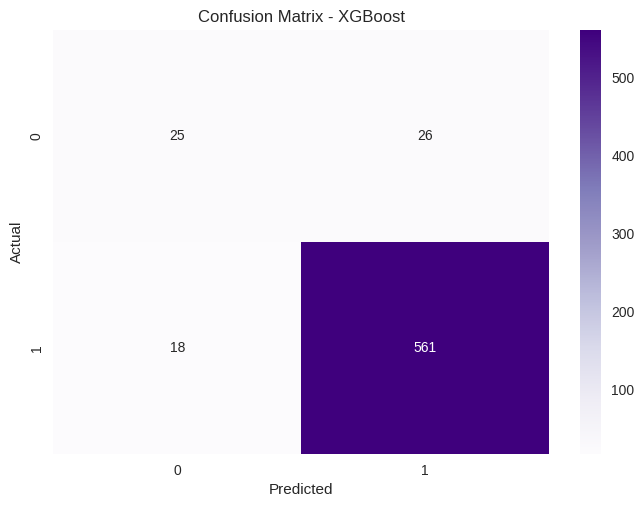

In [31]:
# Train
xgb = XGBClassifier(eval_metric="logloss", use_label_encoder=False, random_state=42)
xgb.fit(X_train_bal, y_train_bal)

# Predict
y_pred_xgb = xgb.predict(X_test_final)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()

## Save Model

dapat dilihat bahwa model yang memiliki akurasi tertinggi adalah xgboost , namun saya memutuskan untuk menggunakan model Logistic Regression karena memiliki nilai recall yang paling tinggi pada kelas negatif sebesar 73% .
hal ini saya sesuaikan dengan kasus dimana mungkin bagi perusahaan lebih berfokus untuk menganalisis dan menangkap review yang negatif .

In [32]:
# # Save & Load Model Terbaik
import joblib

# Simpan model
joblib.dump(lr, "best_model.pkl")
print("✅ Model berhasil disimpan: best_model.pkl")

# Simpan TF-IDF vectorizer & OneHotEncoder
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
joblib.dump(ohe, "onehot_encoder.pkl")
print("✅ Vectorizer & Encoder disimpan")

✅ Model berhasil disimpan: best_model.pkl
✅ Vectorizer & Encoder disimpan
